In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
import pickle
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<50
belgium_region=((map-belgium_color)**2).sum(-1)<10000


b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
np.random.seed(55)
num_points_to_sample=10000 #10000
belgium_coords_sample=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords_sample=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]
X_sample=np.vstack((netherlands_coords_sample, belgium_coords_sample))
y_sample=np.concatenate((np.zeros(len(belgium_coords_sample)), np.ones(len(netherlands_coords_sample)))).astype('int')
rI=np.arange(len(y_sample))
np.random.shuffle(rI)
X_sample=X_sample[rI,:]
y_sample=y_sample[rI]
X_sample = torch.FloatTensor(X_sample)
y_sample = torch.tensor(y_sample)

#Skip sampling train on all. 
belgium_coords=belgium_coords_all
netherlands_coords=netherlands_coords_all

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

In [4]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
def viz_descision_boundary(model, res=256):
    plt.clf()
    fig=plt.figure(0,(6,6))
    ax=fig.add_subplot(111)
    
    probe=np.zeros((res,res,2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(res**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(res,res,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')


## [2]

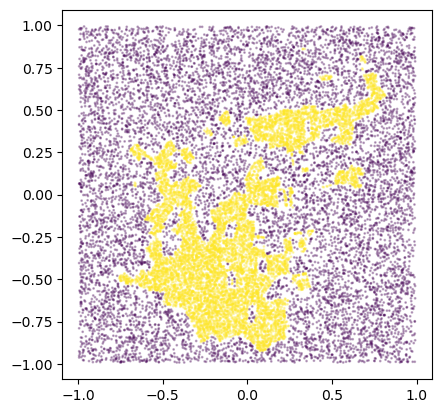

In [6]:
plt.scatter(X_sample[:,0], X_sample[:,1], c=y_sample, s=1, alpha=0.3); plt.axis('square');

In [7]:
X_sample.shape

torch.Size([20000, 2])

In [8]:
random_seed=25
num_epochs = 1
batch_size = 1

device='cpu'

torch.manual_seed(random_seed)  

# Initialize model and optimizer
model = BaarleNet([2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Data storage for this run
training_data = {
    'seed': random_seed,
    'weights_history': [],
    #'gradients_history': [],
    #'xy_history': [],
    'loss_history': [],
    #'accuracy_history': []
}

num_epochs = 2500
for epoch in range(num_epochs):

    #Stochastic
    outputs = model(X_sample[epoch%len(y_sample)])
    loss = criterion(outputs, y_sample[epoch%len(y_sample)])
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    
    # Store model weights (deep copy to avoid reference issues)
    current_weights = {}
    for name, param in model.named_parameters():
        current_weights[name] = param.data.clone()
    training_data['weights_history'].append(current_weights)
    
    # Store loss
    training_data['loss_history'].append(loss.item())
    
    optimizer.step()
    if (epoch+1) % (num_epochs//25) == 0:
        outputs_batch = model(X_sample)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_sample).sum().item()/len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [100/2500], Loss: 0.7533, Accuracy: 0.5915
Epoch [200/2500], Loss: 0.5792, Accuracy: 0.7205
Epoch [300/2500], Loss: 0.4383, Accuracy: 0.6958
Epoch [400/2500], Loss: 0.3955, Accuracy: 0.7405
Epoch [500/2500], Loss: 0.6249, Accuracy: 0.7783
Epoch [600/2500], Loss: 0.2783, Accuracy: 0.7643
Epoch [700/2500], Loss: 0.4005, Accuracy: 0.7529
Epoch [800/2500], Loss: 0.3043, Accuracy: 0.7349
Epoch [900/2500], Loss: 0.0042, Accuracy: 0.7672
Epoch [1000/2500], Loss: 0.3505, Accuracy: 0.7736
Epoch [1100/2500], Loss: 1.6036, Accuracy: 0.7762
Epoch [1200/2500], Loss: 0.0410, Accuracy: 0.7789
Epoch [1300/2500], Loss: 0.1741, Accuracy: 0.7733
Epoch [1400/2500], Loss: 0.2200, Accuracy: 0.7800
Epoch [1500/2500], Loss: 1.7097, Accuracy: 0.7742
Epoch [1600/2500], Loss: 0.3208, Accuracy: 0.7783
Epoch [1700/2500], Loss: 0.0428, Accuracy: 0.7653
Epoch [1800/2500], Loss: 0.0199, Accuracy: 0.7678
Epoch [1900/2500], Loss: 0.1885, Accuracy: 0.7781
Epoch [2000/2500], Loss: 1.1976, Accuracy: 0.7778
Epoch [21

<Figure size 640x480 with 0 Axes>

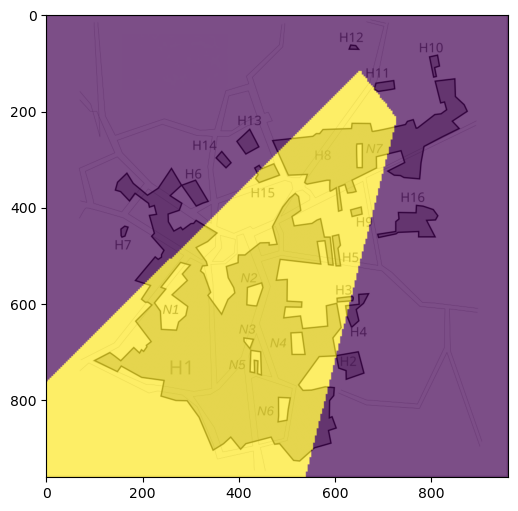

In [9]:
viz_descision_boundary(model)

In [10]:
output_dir='/home/stephen/backprop3/training_caches'
os.makedirs(output_dir, exist_ok=True)
filename = os.path.join(output_dir, '2_1.pkl')
with open(filename, 'wb') as f:
    pickle.dump(training_data, f)

## [3]

In [6]:
y_sample[0]

tensor(1)

In [11]:
X_sample[0].numpy().tolist()

[0.5354166626930237, 0.4416666626930237]

In [8]:
# X_sample[epoch%len(y_sample)]).numpy().list()

SyntaxError: unmatched ')' (1831414031.py, line 1)

In [43]:
random_seed=8
num_epochs = 1
batch_size = 1

device='cpu'

torch.manual_seed(random_seed)  

# Initialize model and optimizer
model = BaarleNet([3]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Data storage for this run
training_data = {
    'seed': random_seed,
    'weights_history': [],
    'gradients_history': [],
    'xy_history': [],
    'loss_history': [],
    #'accuracy_history': []
}

num_epochs = 2500
for epoch in range(num_epochs):

    #Stochastic
    outputs = model(X_sample[epoch%len(y_sample)])
    loss = criterion(outputs, y_sample[epoch%len(y_sample)])
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # Store current X,y values
    training_data['xy_history'].append({
        'epoch': epoch,
        'x': X_sample[epoch%len(y_sample)].numpy().tolist(),
        'y':  y_sample[epoch%len(y_sample)].item()
    })

    current_gradients = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            current_gradients[name] = param.grad.clone()
        else:
            current_gradients[name] = None
    training_data['gradients_history'].append(current_gradients)

    # Store model weights (deep copy to avoid reference issues)
    current_weights = {}
    for name, param in model.named_parameters():
        current_weights[name] = param.data.clone()
    training_data['weights_history'].append(current_weights)
    
    # Store loss
    training_data['loss_history'].append(loss.item())
    
    optimizer.step()
    if (epoch+1) % (num_epochs//25) == 0:
        outputs_batch = model(X_sample)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_sample).sum().item()/len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [100/2500], Loss: 1.1597, Accuracy: 0.5000
Epoch [200/2500], Loss: 0.5538, Accuracy: 0.6932
Epoch [300/2500], Loss: 0.3317, Accuracy: 0.6921
Epoch [400/2500], Loss: 0.3621, Accuracy: 0.7270
Epoch [500/2500], Loss: 0.4041, Accuracy: 0.7575
Epoch [600/2500], Loss: 0.1709, Accuracy: 0.7627
Epoch [700/2500], Loss: 0.3859, Accuracy: 0.7431
Epoch [800/2500], Loss: 0.3716, Accuracy: 0.7213
Epoch [900/2500], Loss: 0.0078, Accuracy: 0.7742
Epoch [1000/2500], Loss: 0.2783, Accuracy: 0.7752
Epoch [1100/2500], Loss: 1.5391, Accuracy: 0.7750
Epoch [1200/2500], Loss: 0.0317, Accuracy: 0.7786
Epoch [1300/2500], Loss: 0.1375, Accuracy: 0.7732
Epoch [1400/2500], Loss: 0.2178, Accuracy: 0.7683
Epoch [1500/2500], Loss: 1.3535, Accuracy: 0.7644
Epoch [1600/2500], Loss: 0.3350, Accuracy: 0.7762
Epoch [1700/2500], Loss: 0.0385, Accuracy: 0.7619
Epoch [1800/2500], Loss: 0.0199, Accuracy: 0.7667
Epoch [1900/2500], Loss: 0.1506, Accuracy: 0.7798
Epoch [2000/2500], Loss: 1.2371, Accuracy: 0.7809
Epoch [21

<Figure size 640x480 with 0 Axes>

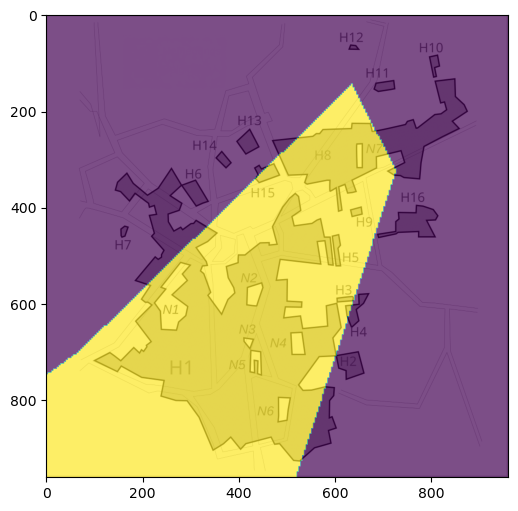

In [44]:
viz_descision_boundary(model)

In [34]:
output_dir='/home/stephen/backprop3/training_caches'
os.makedirs(output_dir, exist_ok=True)
filename = os.path.join(output_dir, '3_2.pkl')
with open(filename, 'wb') as f:
    pickle.dump(training_data, f)

OSError: [Errno 45] Operation not supported: '/home/stephen'

## [4]

## [2 2]

## [3 3]

## [8 8]

In [11]:
random_seed=25
# Data storage for this run
training_data = {
    'seed': random_seed,
    'weights_history': [],
    #'gradients_history': [],
    #'xy_history': [],
    'loss_history': [],
    #'accuracy_history': []
}

In [12]:
device='cpu'
batch_size = 10000
torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([8, 8]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) #Try a little higher lr, see if we can sped things up. 0.005 worked really well
num_epochs = 1000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
    
        # Store model weights (deep copy to avoid reference issues)
        if epoch<20:
            current_weights = {}
            for name, param in model.named_parameters():
                current_weights[name] = param.data.clone()
            training_data['weights_history'].append(current_weights)
            
            # Store loss
            training_data['loss_history'].append(loss.item())
    
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1

    if epoch>20:
        current_weights = {}
        for name, param in model.named_parameters():
            current_weights[name] = param.data.clone()
        training_data['weights_history'].append(current_weights)
        
        # Store loss
        training_data['loss_history'].append(loss.item())

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 100) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [10/1000], Loss: 0.1923, Accuracy: 0.8541
Epoch [20/1000], Loss: 0.1876, Accuracy: 0.8498
Epoch [30/1000], Loss: 0.1832, Accuracy: 0.8533
Epoch [40/1000], Loss: 0.1821, Accuracy: 0.8482
Epoch [50/1000], Loss: 0.1813, Accuracy: 0.8605
Epoch [60/1000], Loss: 0.1806, Accuracy: 0.8743
Epoch [70/1000], Loss: 0.1774, Accuracy: 0.8769
Epoch [80/1000], Loss: 0.1754, Accuracy: 0.8877
Epoch [90/1000], Loss: 0.1733, Accuracy: 0.8881
Epoch [100/1000], Loss: 0.1711, Accuracy: 0.8859
Epoch [110/1000], Loss: 0.1692, Accuracy: 0.8867
Epoch [120/1000], Loss: 0.1690, Accuracy: 0.8823
Epoch [130/1000], Loss: 0.1677, Accuracy: 0.8999
Epoch [140/1000], Loss: 0.1676, Accuracy: 0.8966
Epoch [150/1000], Loss: 0.1667, Accuracy: 0.8818
Epoch [160/1000], Loss: 0.1666, Accuracy: 0.8776
Epoch [170/1000], Loss: 0.1661, Accuracy: 0.8872
Epoch [180/1000], Loss: 0.1661, Accuracy: 0.8897
Epoch [190/1000], Loss: 0.1663, Accuracy: 0.8817
Epoch [200/1000], Loss: 0.1655, Accuracy: 0.8915
Epoch [210/1000], Loss: 0.165

<Figure size 640x480 with 0 Axes>

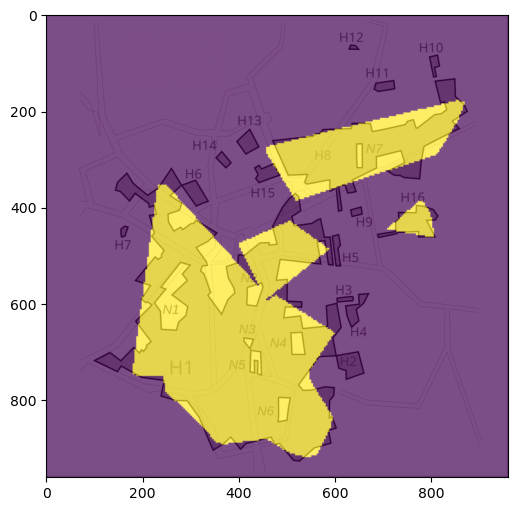

In [13]:
viz_descision_boundary(model)

In [ ]:
output_dir='/home/stephen/backprop3/training_caches'
os.makedirs(output_dir, exist_ok=True)
filename = os.path.join(output_dir, '8_8_1.pkl')
with open(filename, 'wb') as f:
    pickle.dump(training_data, f)

## [16 16 ]

## [16 16 16]

## [32 32 32 32]

In [11]:
# Data storage for this run
training_data = {
    'seed': random_seed,
    'weights_history': [],
    #'gradients_history': [],
    #'xy_history': [],
    'loss_history': [],
    #'accuracy_history': []
}

In [12]:
device='cpu'
batch_size = 10000
random_seed=25

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([32, 32, 32, 32]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) #Try a little higher lr, see if we can sped things up. 0.005 worked really well
num_epochs = 1000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
    
        # Store model weights (deep copy to avoid reference issues)
        if epoch<20:
            current_weights = {}
            for name, param in model.named_parameters():
                current_weights[name] = param.data.clone()
            training_data['weights_history'].append(current_weights)
            
            # Store loss
            training_data['loss_history'].append(loss.item())
    
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1

    if epoch>20:
        current_weights = {}
        for name, param in model.named_parameters():
            current_weights[name] = param.data.clone()
        training_data['weights_history'].append(current_weights)
        
        # Store loss
        training_data['loss_history'].append(loss.item())

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 100) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [10/1000], Loss: 0.0917, Accuracy: 0.9507
Epoch [20/1000], Loss: 0.0702, Accuracy: 0.9649
Epoch [30/1000], Loss: 0.0616, Accuracy: 0.9517
Epoch [40/1000], Loss: 0.0576, Accuracy: 0.9614
Epoch [50/1000], Loss: 0.0557, Accuracy: 0.9551
Epoch [60/1000], Loss: 0.0510, Accuracy: 0.9715
Epoch [70/1000], Loss: 0.0472, Accuracy: 0.9728
Epoch [80/1000], Loss: 0.0477, Accuracy: 0.9721
Epoch [90/1000], Loss: 0.0435, Accuracy: 0.9704
Epoch [100/1000], Loss: 0.0424, Accuracy: 0.9796
Epoch [110/1000], Loss: 0.0380, Accuracy: 0.9805
Epoch [120/1000], Loss: 0.0384, Accuracy: 0.9754
Epoch [130/1000], Loss: 0.0355, Accuracy: 0.9788
Epoch [140/1000], Loss: 0.0346, Accuracy: 0.9700
Epoch [150/1000], Loss: 0.0333, Accuracy: 0.9775
Epoch [160/1000], Loss: 0.0331, Accuracy: 0.9779
Epoch [170/1000], Loss: 0.0300, Accuracy: 0.9715
Epoch [180/1000], Loss: 0.0325, Accuracy: 0.9726
Epoch [190/1000], Loss: 0.0300, Accuracy: 0.9836
Epoch [200/1000], Loss: 0.0296, Accuracy: 0.9800
Epoch [210/1000], Loss: 0.034

In [13]:
len(dataloader)

86

<Figure size 640x480 with 0 Axes>

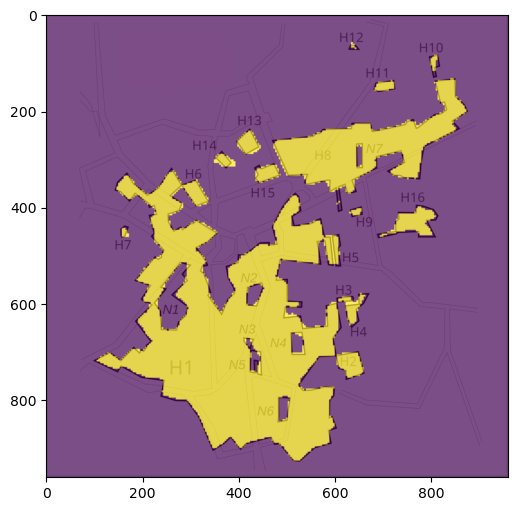

In [14]:
viz_descision_boundary(model)

In [15]:
output_dir='/home/stephen/backprop3/training_caches'
os.makedirs(output_dir, exist_ok=True)
filename = os.path.join(output_dir, '32_32_32_32_1.pkl')
with open(filename, 'wb') as f:
    pickle.dump(training_data, f)